In [1]:
# Libraries
import numpy as np
import pandas as pd
import torch
from modules.energy_consumption_net import EnergyConsumptionNet, train_epochs
from modules.energy_consumption_dataset import EnergyConsumptionDataset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.colors as mc

# Register converters to plot datetime axis
pd.plotting.register_matplotlib_converters()

# Setup matplotlib plotting
%matplotlib inline

In [2]:
# Read dataset
ds = pd.read_csv('data/ready.csv', parse_dates=['datetime'], index_col='datetime')
# We want to have 2018 in last positions of the array (due to Neural Network layout)
# So, dataset is sorted accordingly
ds.sort_index(ascending=True, inplace=True)
# Show dataset
ds.head()

,AEP,DAYTON,DOM,DUQ
datetime,,,,
2006-01-01 00:00:00,14565.0,1769.0,9649.0,1493.0
2006-01-01 01:00:00,14287.0,1697.0,9258.0,1255.0
2006-01-01 02:00:00,13932.0,1635.0,8987.0,1338.0
2006-01-01 03:00:00,13713.0,1584.0,8781.0,1276.0
2006-01-01 04:00:00,13656.0,1553.0,8680.0,1251.0


In [3]:
# Split original dataset into training and testing
ds_train = ds.loc[:'2017-01-01 00:00:00']
ds_test = ds.loc['2017-01-01 00:00:00':]

# Check train and test datasets
print('Train dataset has {:d} rows ({:.0f}%)'.format(ds_train.shape[0], ds_train.shape[0] / ds.shape[0] * 100))
print('Test dataset has {:d} rows ({:.0f}%)'.format(ds_test.shape[0], ds_test.shape[0] / ds.shape[0] * 100))

Train dataset has 96433 rows (87%)
Test dataset has 13897 rows (13%)


In [4]:
# Define PyTorch Datasets for testing univariate LSTM
lag = 3  # Lag
train = EnergyConsumptionDataset(ds_train[['AEP']], lag=lag)
test = EnergyConsumptionDataset(ds_test[['AEP']], col_max=train.max, col_min=train.min, lag=lag)

In [5]:
# Define network (10 lags)
univariate = EnergyConsumptionNet(input_size=1, hidden_size=128, num_layers=2, dropout=0.3)
# Move net to GPU
univariate.to(torch.device('cpu'))

# Load weigths from disk
univariate.load_state_dict(torch.load('models/univariate.pt'))

<All keys matched successfully>

In [6]:
# Forecast using univariate LSTM test data only

# Predict on whole training dataset
with torch.no_grad():
    # Set the net in evaluation mode
    univariate.eval()
    # Define datetime indices for every predicted value
    test_index = test.dataset.index[test.lag:]
    # Make predictions on test set
    univariate_in = torch.cat([test[i].unsqueeze(0) for i in range(len(test))])
    test_pred, _ = univariate(univariate_in[:, :-1, :])
    
# Cast retrieved forecast as lists
test_pred = test_pred[:, -1, 0].squeeze().numpy()
# Rescale output
test_pred = test_pred * (train.max[0] - train.min[0]) + train.min[0]

# Define datetime -> (true, train, test) dataset for forecasting
uni_forecast = ds[['AEP']].copy().rename(columns={ds.columns[0]: 'true'})
# Add empty columns for test
uni_forecast['test'] = np.nan
# Fill test data
uni_forecast.loc[test_index, 'test'] = np.array(test_pred, dtype=np.float)
# Keep only valid data
uni_forecast = uni_forecast[(~uni_forecast.true.isnull()) & (~uni_forecast.test.isnull())]
# Check forecast dataset
uni_forecast

,true,test
datetime,,
2017-01-01 03:00:00,12487.0,12481.108398
2017-01-01 04:00:00,12369.0,12505.322266
2017-01-01 05:00:00,12490.0,12404.982422
2017-01-01 06:00:00,12646.0,12660.414062
2017-01-01 07:00:00,12936.0,12848.729492
...,...,...
2018-08-02 20:00:00,17673.0,17551.181641
2018-08-02 21:00:00,17303.0,17130.859375
2018-08-02 22:00:00,17001.0,16837.669922


In [7]:
# Define PyTorch Datasets for testing multivariate LSTM
lag = 3  # Lag
train = EnergyConsumptionDataset(ds_train, lag=lag)
test = EnergyConsumptionDataset(ds_test, col_max=train.max, col_min=train.min, lag=lag)

In [8]:
# Multivariate LSTM

# Define network (10 lags)
multivariate = EnergyConsumptionNet(input_size=4, hidden_size=128, num_layers=2, dropout=0.3)
# Move net to GPU
multivariate.to(torch.device('cpu'))

# Load weigths from disk
multivariate.load_state_dict(torch.load('models/multivariate.pt'))

<All keys matched successfully>

In [9]:
# Forecast using multivariate LSTM test data only

# Predict on whole training dataset
with torch.no_grad():
    # Set the net in evaluation mode
    univariate.eval()
    # Define datetime indices for every predicted value
    test_index = test.dataset.index[test.lag:]
    # Make predictions on test set
    multivariate_in = torch.cat([test[i].unsqueeze(0) for i in range(len(test))])
    test_pred, _ = multivariate(multivariate_in[:, :-1, :])
    
# Cast retrieved forecast as lists
test_pred = test_pred[:, -1, 0].squeeze().numpy()
# Rescale output
test_pred = test_pred * (train.max[0] - train.min[0]) + train.min[0]

# Define datetime -> (true, train, test) dataset for forecasting
multi_forecast = ds[['AEP']].copy().rename(columns={ds.columns[0]: 'true'})
# Add empty columns for test
multi_forecast['test'] = np.nan
# Fill test data
multi_forecast.loc[test_index, 'test'] = np.array(test_pred, dtype=np.float)
# Keep only valid data
multi_forecast = multi_forecast[(~multi_forecast.true.isnull()) & (~multi_forecast.test.isnull())]
# Check forecast dataset
multi_forecast

,true,test
datetime,,
2017-01-01 03:00:00,12487.0,12424.589844
2017-01-01 04:00:00,12369.0,12445.226562
2017-01-01 05:00:00,12490.0,12302.208984
2017-01-01 06:00:00,12646.0,12542.237305
2017-01-01 07:00:00,12936.0,12719.951172
...,...,...
2018-08-02 20:00:00,17673.0,17865.109375
2018-08-02 21:00:00,17303.0,17325.746094
2018-08-02 22:00:00,17001.0,16851.492188


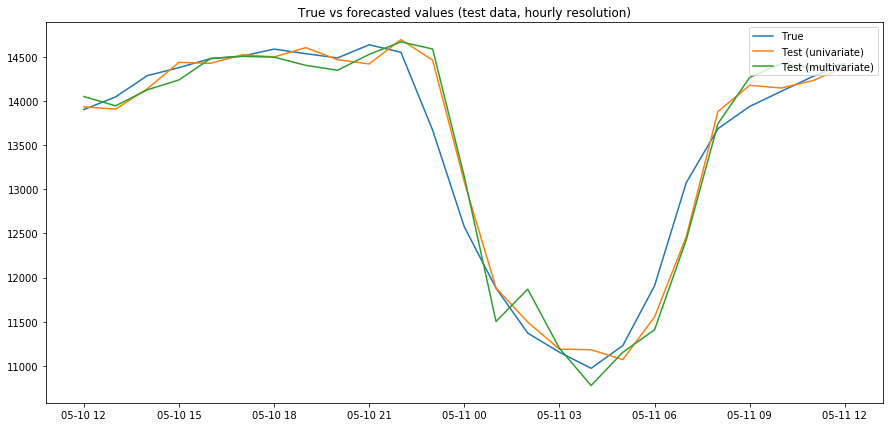

In [20]:
# Regression comparison on a few hours interval
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('True vs forecasted values (test data, hourly resolution)')
_ = ax.plot(uni_forecast['2017-05-10 12:00:00':'2017-05-11 12:00:00'].true, '-')
_ = ax.plot(uni_forecast['2017-05-10 12:00:00':'2017-05-11 12:00:00'].test, '-')
_ = ax.plot(multi_forecast['2017-05-10 12:00:00':'2017-05-11 12:00:00'].test, '-')
_ = ax.legend(['True', 'Test (univariate)', 'Test (multivariate)'], loc='upper right')
_ = plt.savefig('images/comparison_test_hourly.png')
_ = plt.show()

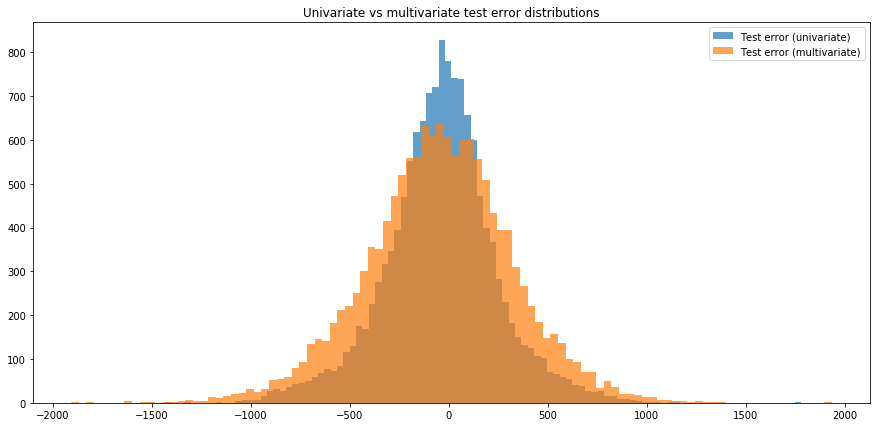

In [22]:
# Errors distribution comparison
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Univariate vs multivariate test error distributions')
_ = ax.hist(uni_forecast.test - uni_forecast.true, bins=100, alpha=.7)
_ = ax.hist(multi_forecast.test - multi_forecast.true, bins=100, alpha=.7)
_ = ax.legend(['Test error (univariate)', 'Test error (multivariate)'])
_ = plt.savefig('images/comparison_error_distribution.png')
_ = plt.show()